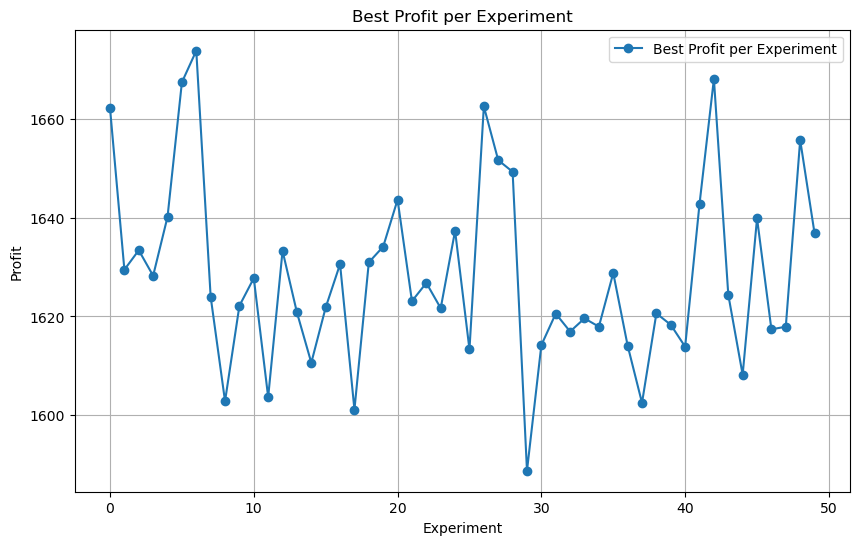

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 参数定义
part1_cost = 4
part2_cost = 18
assemble_cost = 6
detect_cost_part1 = [2, 2, 2, 1, 8, 2]
detect_cost_part2 = [3, 3, 3, 1, 1, 3]
detect_cost_final = [3, 3, 3, 2, 2, 3]
market_price = 56
replace_loss = [6, 6, 30, 30, 10, 10]
decompose_cost = [5, 5, 5, 5, 5, 40]

# 生产成品数量
N = 100
# 蒙特卡洛模拟次数
simulations = 100

# 计算多个成品的销量与利润
def compute_total_sales_and_profit(d1, d2, d3, d4, N, situation, part1_defect_rate, part2_defect_rate, final_product_defect_rate):
    defect_rate_part1 = part1_defect_rate[situation] if d1 == 0 else 0
    defect_rate_part2 = part2_defect_rate[situation] if d2 == 0 else 0
    basic_defect_rate = final_product_defect_rate[situation]
    product_defect_rate = 1 - (1 - defect_rate_part1) * (1 - defect_rate_part2) * (1 - basic_defect_rate)
    
    # 计算合格产品数量与销售额
    total_sales = N * (1 - product_defect_rate)
    total_revenue = total_sales * market_price

    # 计算成本
    part1_total_cost = N * (part1_cost + (detect_cost_part1[situation] if d1 == 1 else 0))
    part2_total_cost = N * (part2_cost + (detect_cost_part2[situation] if d2 == 1 else 0))
    assembly_total_cost = N * (assemble_cost + (detect_cost_final[situation] if d3 == 1 else 0))
    
    # 如果未检测成品且次品，则产生调换损失
    replacement_loss = N * product_defect_rate * replace_loss[situation] if d4 == 0 else 0
    
    # 拆解成本
    decompose_total_cost = decompose_cost[situation] if d4 == 1 else 0

    # 总成本
    total_cost = part1_total_cost + part2_total_cost + assembly_total_cost + replacement_loss + decompose_total_cost
    
    # 总利润 = 总收入 - 总成本
    total_profit = total_revenue - total_cost
    
    return total_sales, total_profit

# 遗传算法的选择、交叉和变异操作
def genetic_algorithm_optimization(simulations, generations=10, population_size=10, mutation_rate=0.1):
    population = [(np.random.randint(0, 2), np.random.randint(0, 2), 
                   np.random.randint(0, 2), np.random.randint(0, 2)) for _ in range(population_size)]
    
    best_strategies = []
    best_sales_per_generation = []
    best_profit_per_generation = []
    avg_profit_per_generation = []
    
    for generation in range(generations):
        sales_for_population = []
        total_profit_generation = []
        
        for strategy in population:
            d1, d2, d3, d4 = strategy
            total_sales_list = []
            total_profit_list = []
            for _ in range(simulations):
                # 生成上下浮动3%的缺陷率
                part1_defect_rate_variation = np.random.uniform(-0.03, 0.03, size=len(part1_defect_rate))
                part2_defect_rate_variation = np.random.uniform(-0.03, 0.03, size=len(part2_defect_rate))
                final_product_defect_rate_variation = np.random.uniform(-0.03, 0.03, size=len(final_product_defect_rate))
                
                part1_defect_rate_modified = part1_defect_rate + part1_defect_rate_variation
                part2_defect_rate_modified = part2_defect_rate + part2_defect_rate_variation
                final_product_defect_rate_modified = final_product_defect_rate + final_product_defect_rate_variation
                
                situation = np.random.randint(0, len(part1_defect_rate))
                total_sales, total_profit = compute_total_sales_and_profit(d1, d2, d3, d4, N, situation, part1_defect_rate_modified, part2_defect_rate_modified, final_product_defect_rate_modified)
                total_sales_list.append(total_sales)
                total_profit_list.append(total_profit)
            avg_sales = np.mean(total_sales_list)
            avg_profit = np.mean(total_profit_list)
            sales_for_population.append((strategy, avg_sales, avg_profit))
            total_profit_generation.append(avg_profit)
        
        best_strategy, best_sales, best_profit = max(sales_for_population, key=lambda x: x[2])
        best_strategies.append(best_strategy)
        best_sales_per_generation.append(best_sales)
        best_profit_per_generation.append(best_profit)
        avg_profit_per_generation.append(np.mean(total_profit_generation))
        
        sorted_population = sorted(sales_for_population, key=lambda x: x[2], reverse=True)
        parent_population = [x[0] for x in sorted_population[:population_size // 2]]
        
        new_population = []
        for _ in range(population_size // 2):
            parent1_idx, parent2_idx = np.random.choice(len(parent_population), size=2, replace=False)
            parent1 = parent_population[parent1_idx]
            parent2 = parent_population[parent2_idx]
            
            crossover_point = np.random.randint(1, 4)
            offspring1 = parent1[:crossover_point] + parent2[crossover_point:]
            offspring2 = parent2[:crossover_point] + parent1[crossover_point:]
            new_population.extend([offspring1, offspring2])
        
        for i in range(len(new_population)):
            if np.random.rand() < mutation_rate:
                mutation_idx = np.random.randint(0, 4)
                new_population[i] = list(new_population[i])
                new_population[i][mutation_idx] = 1 - new_population[i][mutation_idx]
                new_population[i] = tuple(new_population[i])
        
        population = new_population

    return best_strategies, best_sales_per_generation, best_profit_per_generation, avg_profit_per_generation

# 启动实验过程
best_strategies_all = []
best_profit_all = []

for exp in range(50):
    # 随机生成缺陷率参数
    part1_defect_rate = [0.1, 0.2, 0.1, 0.2, 0.1, 0.05]
    part2_defect_rate = [0.1, 0.2, 0.1, 0.2, 0.2, 0.05]
    final_product_defect_rate = [0.1, 0.2, 0.1, 0.2, 0.1, 0.05]

    # 启动遗传算法
    best_strategies, _, best_profit_per_generation, _ = genetic_algorithm_optimization(simulations, generations=500, population_size=20, mutation_rate=0.1)
    
    best_strategies_all.append(best_strategies[-1])
    best_profit_all.append(best_profit_per_generation[-1])

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(range(50), best_profit_all, label='Best Profit per Experiment', marker='o')
plt.xlabel('Experiment')
plt.ylabel('Profit')
plt.title('Best Profit per Experiment')
plt.legend()
plt.grid(True)
plt.show()

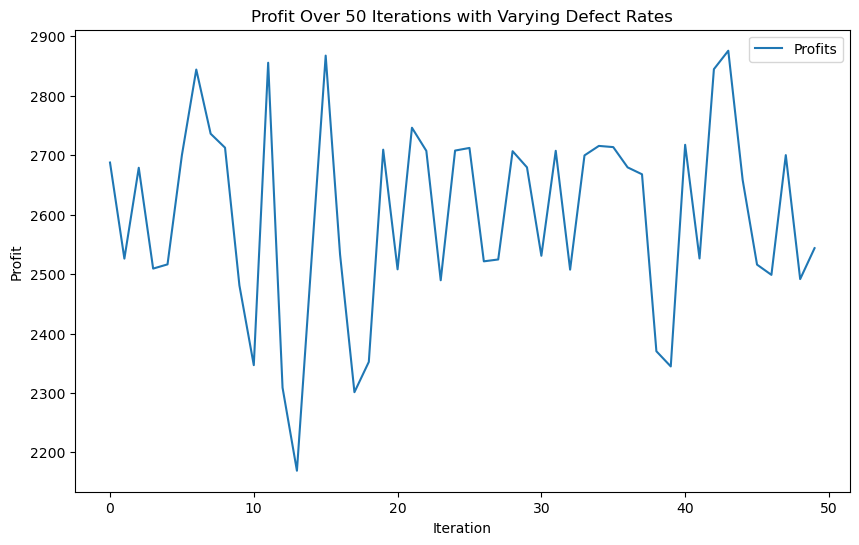

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 参数定义
p = 200  # 成品的市场售价
m = 2  # 工序数
n = 8  # 零配件数
N = 100  # 假设的生产数量

# 零配件次品率、成本、检测成本
q_ij = [0.1] * n  # 每个零配件的次品率
c_ij = [2, 8, 12, 2, 8, 12, 8, 12]  # 零配件的成本
d_ij = [1, 1, 2, 1, 1, 2, 1, 2]  # 零配件检测成本

# 成品次品率、装配成本、检测成本
p_f = 0.1  # 成品次品率
c_f = 8  # 成品装配成本
d_f = 6  # 成品检测成本
r = 40  # 成品调换损失
d_c = 10  # 成品拆解成本

# 决策变量生成函数（遗传算法种群初始化）
def generate_population(size):
    population = []
    for _ in range(size):
        # 每个个体包括 m*n 个零配件的检测决策，1个成品检测决策，1个拆解决策
        x_ij = np.random.randint(0, 2, size=(m, n))  # 零配件检测决策
        x_f = np.random.randint(0, 2)  # 成品检测决策
        x_d = np.random.randint(0, 2)  # 拆解决策
        population.append((x_ij, x_f, x_d))
    return population

# 计算利润和销量的函数
def compute_profit_and_sales(x_ij, x_f, x_d, simulations, q_ij, p_f):
    total_profits = []
    total_sales = []
    
    for _ in range(simulations):  # 进行多次模拟
        total_profit = 0
        total_sales_for_simulation = 0
        defect_rate = 1  # 初始次品率为 1
        
        # 零配件阶段利润和次品率计算
        for i in range(m):
            for j in range(n):
                if x_ij[i][j] == 0:
                    total_profit -= c_ij[j]  # 不检测，直接产生成本
                else:
                    # 检测后减少次品率
                    total_profit += (1 - q_ij[j]) * (p - c_ij[j] - d_ij[j])
                    defect_rate *= (1 - q_ij[j])

        # 成品阶段利润计算
        if x_f == 0:
            total_profit += (1 - p_f) * p - c_f - r  # 不检测
            defect_rate *= p_f
        else:
            total_profit += (1 - p_f) * (p - d_f) - c_f  # 检测后利润
            defect_rate *= (1 - p_f)

        # 计算合格产品数量（销量）
        qualified_products = (1 - defect_rate) * N
        total_sales_for_simulation = qualified_products

        # 拆解阶段利润计算
        if x_d == 0:
            total_profit -= d_c  # 不拆解
        else:
            total_profit += sum([p_j * (p - c_ij[j]) for j, p_j in enumerate(q_ij)])  # 拆解后回收零配件

        total_profits.append(total_profit)
        total_sales.append(total_sales_for_simulation)

    # 返回多次模拟的平均利润和平均销量
    avg_profit = np.mean(total_profits)
    avg_sales = np.mean(total_sales)
    return avg_profit, avg_sales

# 遗传算法主流程
def genetic_algorithm_optimization(pop_size, generations, simulations, mutation_rate, q_ij, p_f):
    # 初始化种群
    population = generate_population(pop_size)
    best_strategy = None
    best_profit = -np.inf
    
    for generation in range(generations):
        profits = []
        
        # 计算每个个体的平均利润和销量（蒙特卡洛模拟）
        for individual in population:
            x_ij, x_f, x_d = individual
            profit, sales = compute_profit_and_sales(x_ij, x_f, x_d, simulations, q_ij, p_f)
            profits.append((individual, profit))
        
        # 找到当前种群中利润最高的个体
        current_best_individual, current_best_profit = max(profits, key=lambda x: x[1])

        # 更新最优个体
        if current_best_profit > best_profit:
            best_strategy = current_best_individual
            best_profit = current_best_profit

        # 选择过程
        sorted_population = sorted(profits, key=lambda x: x[1], reverse=True)
        parent_population = [x[0] for x in sorted_population[:pop_size // 2]]

        # 交叉生成后代
        new_population = []
        for _ in range(pop_size // 2):
            parent1, parent2 = np.random.choice(len(parent_population), size=2, replace=False)
            parent1 = parent_population[parent1]
            parent2 = parent_population[parent2]
            
            # 交叉点的选择
            crossover_point = np.random.randint(1, n)
            offspring1_x_ij = np.vstack((parent1[0][:crossover_point], parent2[0][crossover_point:]))
            offspring2_x_ij = np.vstack((parent2[0][:crossover_point], parent1[0][crossover_point:]))

            offspring1 = (offspring1_x_ij, parent1[1], parent1[2])
            offspring2 = (offspring2_x_ij, parent2[1], parent2[2])
            new_population.extend([offspring1, offspring2])

        # 变异过程
        for i in range(len(new_population)):
            if np.random.rand() < mutation_rate:
                mutation_idx = np.random.randint(0, n)
                new_population[i][0][0][mutation_idx] = 1 - new_population[i][0][0][mutation_idx]  # 变异

        population = new_population

    return best_strategy, best_profit

# 进行50次变化
profits = []
strategies = []

for _ in range(50):
    # 随机浮动零配件次品率和成品次品率
    fluctuated_q_ij = [q + np.random.uniform(-0.03, 0.03) for q in q_ij]
    fluctuated_p_f = p_f + np.random.uniform(-0.03, 0.03)

    # 优化
    best_strategy, best_profit = genetic_algorithm_optimization(
        pop_size=10,  # 种群大小
        generations=500,  # 迭代次数
        simulations=100,  # 蒙特卡洛模拟次数
        mutation_rate=0.1,  # 变异率
        q_ij=fluctuated_q_ij,
        p_f=fluctuated_p_f
    )
    
    profits.append(best_profit)
    strategies.append(best_strategy)

# 绘制利润变化图
plt.figure(figsize=(10, 6))
plt.plot(profits, label='Profits')
plt.xlabel('Iteration')
plt.ylabel('Profit')
plt.title('Profit Over 50 Iterations with Varying Defect Rates')
plt.legend()
plt.show()